# Майнор Интеллектуальный анализ данных / Введение в анализ данных

## Домашнее задание 3. Логистическая регрессия и случайный лес.

В этом задании вам предстоит:
- поработать с логистической регрессией (полная реализация не потребуется, однако можно заработать бонусные баллы)
- воспроизвести подход случайного леса через одно решающее дерево, поэкспериментировать со случайным лесом.

На все вопросы требуется отвечать развёрнуто, аппелируя к полученным значениям или графикам, ответы вписывать в отдельную ячейку, выбрав для неё тип "Markdown". От полноты и качества ответов будет во многом зависеть ваша итоговая оценка.

Задание выполняется самостоятельно, плагиат будет стандартно наказываться лишением всех баллов за задание.
- Максимальная оценка за задание: 10 баллов.
- Дата выдачи: 28.04.2018
- Срок сдачи: 23:59 18.05.2018

In [0]:
%pylab inline
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


## Часть 0. Подготовка данных.

Для наших экспериентов возьмём обучающую выборку [отсюда](https://www.kaggle.com/iabhishekofficial/mobile-price-classification).

In [0]:
train = pd.read_csv('train.csv')

Решается задача многоклассовой классификации — определение ценовой категории телефона. Для простоты перейдём к задаче бинарной классификации — пусть исходные классы 0 и 1 соответствуют классу 0 новой целевой переменной, а остальные классу 1.

Замените целевую переменную, отделите её в отдельную переменную и удалите из исходной выборки.

In [0]:
new = []

for i in train.price_range:
    if i == 0 or i == 1:
        new.append(0)
    else:
        new.append(1)

In [0]:
train = train.drop('price_range', 1)

Разделите выборку на обучающую и тестовую части в соотношении 7 к 3. Для этого можно использовать `train_test_split` из scikit-learn. Не забудьте зафиксировать сид для разбиения.

In [0]:
from sklearn.model_selection import train_test_split
x_train, x_test = train_test_split(train, train_size = 0.7, test_size = 0.3, shuffle = False, random_state = 7)
target_train, target_test = train_test_split(new, train_size = 0.7, test_size = 0.3, shuffle = False, random_state = 7)
print(np.array(x_test).shape[0], np.array(x_train).shape[0])

600 1400


## Часть 1. Логистическая регрессия.

[4 балла]

В этой части вы будете обучать самый простой бинарный классификатор — логистическую регрессию. Будем использовать готовую реализацию `LogisticRegression` из scikit-learn.

Логистическая регрессия — линейный метод, то есть в нём предсказание алгоритма вычислаяется как скалярное произведение признаков и весов алгоритма: 

$$
b(x) = w_0 + \langle w, x \rangle = w_0 + \sum_{i=1}^{d} w_i x_i
$$

Для вычисления вероятности положительного класса применяется сигмода. В результате предсказание вероятности принадлежности объекта к положительному классу можно записать как: 

$$
P(y = +1 | x) = \frac{1}{1 + \exp(- w_0 - \langle w, x \rangle )}
$$

Не забывайте, что для линейных методов матрицу объекты-признаки необходимо предварительно нормировать (то есть привести каждый признак к одному и тому же масштабу одним из способов). Для этого можно воспользоваться `StandardScaler` или сделать это вручную.

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
print(x_train[:5])
scaler = StandardScaler()
x_train_norm = pd.DataFrame(scaler.fit_transform(x_train))
x_train_norm.columns = x_train.columns

x_test_norm = pd.DataFrame(scaler.fit_transform(x_test))
x_test_norm.columns = x_train.columns
print(x_train_norm[:5])

   battery_power  blue  clock_speed  dual_sim  fc  four_g  int_memory  m_dep  \
0            842     0          2.2         0   1       0           7    0.6   
1           1021     1          0.5         1   0       1          53    0.7   
2            563     1          0.5         1   2       1          41    0.9   
3            615     1          2.5         0   0       0          10    0.8   
4           1821     1          1.2         0  13       1          44    0.6   

   mobile_wt  n_cores  pc  px_height  px_width   ram  sc_h  sc_w  talk_time  \
0        188        2   2         20       756  2549     9     7         19   
1        136        3   6        905      1988  2631    17     3          7   
2        145        5   6       1263      1716  2603    11     2          9   
3        131        6   9       1216      1786  2769    16     8         11   
4        141        2  14       1208      1212  1411     8     2         15   

   three_g  touch_screen  wifi  
0        0 

Обучите логистическую регрессию. Сделайте предсказания для тестовой части, посчитайте по ним ROC-AUC и Accuracy (порог 0.5). Хорошо ли удаётся предсказывать целевую переменную?

Не забывайте, что метод `predict_proba` вычисляет вероятности обоих классов выборки, а в бинарной классификации нас интересует в первую очередь вероятность принадлежности к положительному классу.

In [0]:
import sklearn.model_selection 
import numpy as np
from sklearn import metrics
LR = LogisticRegression()
LR = LR.fit(x_train_norm, target_train)
pred = np.array(LR.predict_proba(x_test_norm))

for i in range(pred.shape[0]):
    if pred[i, 1] > 0.5:
        pred[i, 1] = 1
    else:
        pred[i, 1] = 0
pred = pred[:, 1]
pred_prob = np.array(LR.predict_proba(x_test_norm)[:,1])
target_test = np.array(target_test)


print('AUC-ROC', metrics.roc_auc_score(target_test, pred_prob))

print('Accuracy', metrics.accuracy_score(target_test, pred))

AUC-ROC 0.999532163743
Accuracy 0.981666666667


У обученной логистической регрессии есть два аттрибута: `coef_` и `intercept_`, которые соответствуют весам $w$ и $w_0$. Это и есть результат обучения логистической регрессии. Попробуйте с помощью них (с помощью всё той же обученной ранее логистической регрессии) посчитать "сырое" предсказание алгоритма $b(x)$. 

Постройте гистограмму полученных значений и ответьте на вопросы:
- Какие значения принимает такое предсказание?
- Похожи ли эти значения на вероятность классов?

Предсказание принимает значение от -19 до 20

да, похожи, можно сказать, что чем ближе предсказание к крайним значениям, тем больше вероятность принадлежности к одному из классов

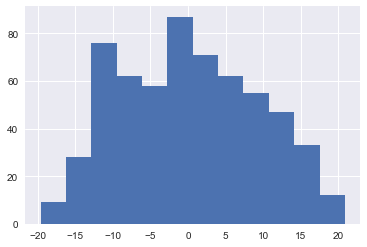

-19.616353508 20.879352249
600


In [0]:
sns.set(font_scale = 1)
import matplotlib.pyplot as plt
raw = []
for i in range(x_test_norm.shape[0]):
    raw.append(*np.dot(LR.coef_ , x_test_norm.loc[i]) + LR.intercept_)
plt.hist(raw, bins='auto')
plt.show()
print(min(raw), max(raw))
print(np.array(raw).size)

Реализуйте сигмоиду и постройте её график. Что вы можете сказать об этой функции?

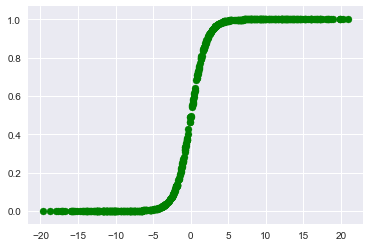

In [0]:
sns.set(font_scale = 1)
y = []
def sigmoid(x):
    a = []
    for item in x:
        a.append(1/(1+math.exp(-item)))
    return a
y = sigmoid(raw)
plt.scatter(raw,y, color='green')
plt.show()

Примените реализованную сигмоиду к $b(x)$. Вы должны получить вероятности принадлежности к положительному классу. Проверьте, что ваши значения совпали с теми, которые получены с помощью `predict_proba`.

In [0]:
print(y-pred_prob)

[  0.00000000e+00  -1.30104261e-18   0.00000000e+00   0.00000000e+00
   0.00000000e+00   6.93889390e-17   2.81892565e-18   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -5.55111512e-17   0.00000000e+00
  -1.08420217e-19   0.00000000e+00   0.00000000e+00   0.00000000e+00
  -5.42101086e-20  -5.55111512e-17   0.00000000e+00   4.40457133e-20
  -2.11758237e-20   0.00000000e+00   0.00000000e+00   0.00000000e+00
   4.33680869e-18   2.77555756e-17   5.55111512e-17   1.66533454e-16
   1.11022302e-16  -6.07153217e-18   5.55111512e-17   0.00000000e+00
   0.00000000e+00   0.00000000e+00   6.35274710e-21  -2.16840434e-18
   0.00000000e+00   1.40946282e-18   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   1.08420217e-18   0.00000000e+00
  -2.22044605e-16   0.00000000e+00  -1.69406589e-21   0.00000000e+00
  -1.51788304e-18   0.00000000e+00   0.00000000e+00  -8.32667268e-17
   5.20417043e-18   1.11022302e-16  -1.51788304e-18   7.63278329e-17
  -4.16333634e-17   0.00000000e+00

Да, большинство значений совпало, у некоторых очень маленькая разница, так что можно сказать, что и они совпали

Таким образом, обучение логистической регрессии — настройка параметров $w$ и $w_0$, а применение — подсчёт вероятностей принадлежности положительному классу как применение сигмоды к скалярному произведению признаков и параметров.

Постройте для обученной логистической регрессии ROC-кривую `roc_curve` и PR-кривую `precision_recall_curve`.

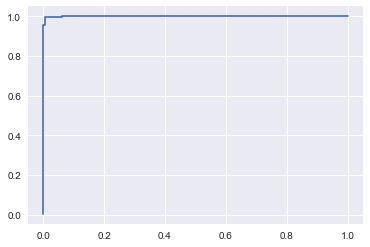

In [0]:
import seaborn as sns

data = np.column_stack((target_test, pred_prob)) 
data = pd.DataFrame(data) 
data.columns = ['target_test', 'pred_prob']
data = data.sort_values(by=['pred_prob'])

fpr, tpr, thresholds = metrics.roc_curve(data['target_test'], data['pred_prob']) 

plt.plot(fpr, tpr)
plt.show()

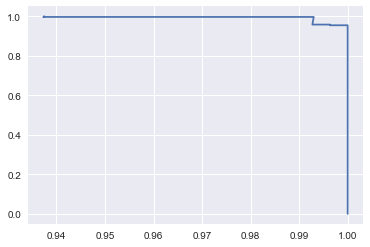

In [0]:
pr, rec, thresholds = metrics.precision_recall_curve(target_test, pred_prob) 

plt.plot(pr, rec) 
plt.show()

### Бонусное задание. Обучение логистической регрессии.

[2 бонусных балла]

Если выше вручную мы только применяли логистическую регрессию, то здесь предлагается реализовать обучение с помощью полного градиентного спуска.

Если кратко, то обучение логистической регрессии с $L_2$-регуляризацией можно записать следующим образом:

$$
Q(w, X) = \frac{1}{l} \sum_{i=1}^{l} \log (1 + \exp(- y_i \langle w, x_i \rangle )) + \frac{\lambda_2}{2} \lVert w \rVert _2^2 \to \min_w
$$

Считаем, что $y_i \in \{-1, +1\}$, а нулевым признаком сделан единичный (то есть $w_0$ соответствует свободному члену). Искать $w$ будем с помощью градиентного спуска:

$$
w^{(k+1)} = w^{(k)} - \alpha \nabla_w Q(w, X)
$$

В случае полного градиентного спуска $\nabla_w Q(w, X)$ считается напрямую (как есть, то есть, используя все объекты выборки). Длину шага $\alpha > 0$ в рамках данного задания предлагается брать равной некоторой малой константе.

Градиент по объекту $x_i$ считается по следующей формуле:

$$
\nabla_w Q(w, x_i) = - \frac{y_i x_i}{1 + \exp(y_i \langle w, x_i \rangle)} + \lambda_2 w
$$

На самом деле неправильно регуляризировать свободный член $w_0$ (то есть при добавлении градиента для $w_0$ не надо учитывать слагаемое с $\lambda_2$). Но в рамках этого задания мы не обращаем на это внимания и работаем со всеми вектором весов одинаково. 

В качестве критерия останова необходимо использовать (одновременно):
- проверку на евклидовую норму разности весов на двух соседних итерациях (например, меньше некоторого малого числа порядка $10^{-6}$) — параметр tolerance
- достижение максимального числа итераций (например, 10000) — параметр max\_iter.

Инициализировать веса можно случайным образом или нулевым вектором.

Реализуйте обучение логистической регрессии. Для удобства ниже предоставлен прототип с необходимыми методами. В `loss_history` необходимо сохранять вычисленное на каждой итерации значение функции потерь. 

In [0]:
from sklearn.base import BaseEstimator

class LogReg(BaseEstimator):
    def __init__(self, lambda_2=1.0, tolerance=1e-4, max_iter=1000, alpha=1e-3):
        """
        lambda_2: L2 regularization param
        tolerance: for stopping gradient descent
        max_iter: maximum number of steps in gradient descent
        alpha: learning rate
        """
        self.lambda_2 = lambda_2
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.alpha = alpha
        self.w = None
        self.loss_history = None
    
    def fit(self, X, y):
        """
        X: np.array of shape (l, d)
        y: np.array of shape (l)
        ---
        output: self
        """
        self.loss_history = []
        
        pass
        
        return self
    
    def predict_proba(self, X):
        """
        X: np.array of shape (l, d)
        ---
        output: np.array of shape (l, 2) where
        first column has probabilities of -1
        second column has probabilities of +1
        """
        if self.w is None:
            raise Exception('Not trained yet')
        
        pass
    
    def calc_gradient(self, X, y):
        """
        X: np.array of shape (l, d) (l can be equal to 1 if stochastic)
        y: np.array of shape (l)
        ---
        output: np.array of shape (d)
        """
        pass

    def calc_loss(self, X, y):
        """
        X: np.array of shape (l, d)
        y: np.array of shape (l)
        ---
        output: float 
        """ 
        pass

1. Примените логистическую регресиию на той же выборке.
2. Посчитайте качество по тем же метрикам.
3. Визуализируйте изменение значений функции потерь от номера итераций.

In [0]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

## Часть 2. Случайные леса.

[6 баллов]

Случайный лес — алгоритм машинного обучения, представляющий собой бэггинг над решающими деревьями (усреднение ответов множества слабых алгоритмов) с 2 основными идеями:
- Использование подмножества признаков при построении каждого сплита дерева.
- Бутстрап обучающей выборки для построения каждого дерева (с повторениями).

В этом задании мы попробуем оценить пользу каждой из идей. Будем использовать ту же выборку с тем же разбиением на 2 части. Для начала обучите решающее дерево `DecisionTreeClassifier` из scikit-learn и посчитайте ROC-AUC и Accuracy (порог 0.5). Не забудьте зафикиксировать сид для построения дерева (несмотря на то, что в классической реализации никакой случайности нет, при большой глубине дерева может возникать неоднозначность в выборке признака в сплите). Используйте этот сид для всех заданий ниже.

In [0]:
from  sklearn.tree  import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state = 7)
clf.fit(x_train, target_train)
pred = np.array(clf.predict_proba(x_test))

for i in range(pred.shape[0]):
    if pred[i, 1] > 0.5:
        pred[i, 1] = 1
    else:
        pred[i, 1] = 0
pred = pred[:, 1]
pred_prob = np.array(clf.predict_proba(x_test)[:,1])
target_test = np.array(target_test)


print('AUC-ROC', metrics.roc_auc_score(target_test, pred_prob))

print('Accuracy', metrics.accuracy_score(target_test, pred))

AUC-ROC 0.934920634921
Accuracy 0.935


### 2.1 Бэггинг классификаторов

Реализуйте бэггинг над решающими деревьями (усреднение предсказанных вероятностей всего ансамбля). 
В качестве основы используйте всё тот же `DecisionTreeClassifier`. Количество базовых алгоритмов предлагается брать равным 100. 

Посчитайте качество с помощью тех же метрик. Ответьте на следующие вопросы:
- Что интересного вы видите?
- С чем это связано?

Можно заметить, что качество предсказаний улучшилось. Это связано с тем, что усреднение ответов большого числа моделей всегда
даёт лучший результат.

In [0]:
from sklearn import model_selection
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier


clf = DecisionTreeClassifier()

model = BaggingClassifier(base_estimator=clf, n_estimators=100, random_state=7)
model.fit(x_train, target_train)
pred = np.array(model.predict_proba(x_test)[:, 1])
pred_prob = np.array(model.predict_proba(x_test)[:, 1])

for i in range(pred.size):
    if pred[i] > 0.5:
        pred[i] = 1
    else:
        pred[i] = 0



print('AUC-ROC', metrics.roc_auc_score(target_test, pred_prob))

print('Accuracy', metrics.accuracy_score(target_test, pred))

AUC-ROC 0.994274575327
Accuracy 0.958333333333


### 2.2 Сэмплирование обучающей выборки

Добавим к нашему бэггингу бутстрап выборки (генерация случайной выборки того же размера с возвращением). Для этого может пригодиться `numpy.random.randint`.

Посчитайте качество. Что вы видите?

Качество упало. Это произошло из-за того, что в обучающей выборке попадаются одинаковые объекты. Разнообразных около 63% от исходных. Также это говорит о

In [0]:
np.random.seed(123)  # для одинакового бутстрапа в каждом запуске

sample = []
sample_target = []

for i in range(x_train.shape[0]):
    temp = np.random.randint(0, x_train.shape[0])
    sample.append(x_train.iloc[temp, :])
    sample_target.append(target_train[temp])

tree = DecisionTreeClassifier()
clf = BaggingClassifier(base_estimator=tree, n_estimators=100, random_state=7)
clf.fit(sample, sample_target)
pred = np.array(clf.predict_proba(x_test))

for i in range(pred.shape[0]):
    if pred[i, 1] > 0.5:
        pred[i, 1] = 1
    else:
        pred[i, 1] = 0
pred = pred[:, 1]
pred_prob = np.array(clf.predict_proba(x_test)[:,1])
target_test = np.array(target_test)


print('AUC-ROC', metrics.roc_auc_score(target_test, pred_prob))

print('Accuracy', metrics.accuracy_score(target_test, pred))

AUC-ROC 0.98955165692
Accuracy 0.943333333333


### 2.3 Выбор случайного подмножества признаков

Временно забудем о бутстрапе выборки и добавим выбор случайного подмножества признаков при построении каждого сплита. В `DecisionTreeClassifier` за это отвечает параметр `max_features`. По умолчанию он имеет значение `None`, что обозначает использование всех возможных признаков. Для задачи классификации рекоменуется использовать квадратный корень от количества признаков. Попробуйте выставить такое значение. На этот раз надо отключить фиксированный сид в построении дерева, так как иначе каждый раз мы будем выбирать одинаковые подмножества признаков. 

Посчитайте качество. Что вы видите?

Качество примерно такое же, как и в пункте 2.2. Эффективность этих методов против переобцчения примерно одинаковая

In [0]:
np.random.seed(123)  # для воспроизводимости построения случайных подмножеств признаков
import math
from  sklearn.tree  import DecisionTreeClassifier

tree = DecisionTreeClassifier(max_features = int(math.sqrt(x_train.shape[1])))
clf = BaggingClassifier(base_estimator=tree, n_estimators=100, random_state=7)
clf.fit(x_train, target_train)
pred = np.array(clf.predict_proba(x_test))

for i in range(pred.shape[0]):
    if pred[i, 1] > 0.5:
        pred[i, 1] = 1
    else:
        pred[i, 1] = 0
pred = pred[:, 1]
pred_prob = np.array(clf.predict_proba(x_test)[:,1])
target_test = np.array(target_test)


print('AUC-ROC', metrics.roc_auc_score(target_test, pred_prob))

print('Accuracy', metrics.accuracy_score(target_test, pred))

AUC-ROC 0.990604288499
Accuracy 0.931666666667


### 2.4 = 2.2 + 2.3

Объединим два подхода (бутстрап + выбор подмножества признаков). Получим случайный лес.

Посчитайте качество. Что вы видите?

Качество стало немного ниже, чем в 2.2 и 2.3. Это произошло из-за того, что сейчас мы боремся с переобучением двумя способами

In [0]:
np.random.seed(123)  # для одинакового бутстрапа и выбора подмножеств признаков в каждом запуске

sample = []
sample_target = []

for i in range(x_train.shape[0]):
    temp = np.random.randint(0, x_train.shape[0])
    sample.append(x_train.iloc[temp, :])
    sample_target.append(target_train[temp])

tree = DecisionTreeClassifier(max_features = int(math.sqrt(x_train.shape[1])))
clf = BaggingClassifier(base_estimator=tree, n_estimators=100, random_state=7)
clf.fit(sample, sample_target)
pred = np.array(clf.predict_proba(x_test))

for i in range(pred.shape[0]):
    if pred[i, 1] > 0.5:
        pred[i, 1] = 1
    else:
        pred[i, 1] = 0
pred = pred[:, 1]
pred_prob = np.array(clf.predict_proba(x_test)[:,1])
target_test = np.array(target_test)


print('AUC-ROC', metrics.roc_auc_score(target_test, pred_prob))

print('Accuracy', metrics.accuracy_score(target_test, pred))

AUC-ROC 0.985419103314
Accuracy 0.925


То, что мы сделали уже реализовано в `RandomForestClassifier`. Попробуйте воспользоваться им. Количество используемых деревьев передаётся в параметре `n_estimators`.

Посчитайте качество. Что вы видите?

Качество RandomForestClassifier примерно такое же, что и при 2.2 + 2.3 Это очевидно, потому что и там и там алгоритм одинаковый.

In [0]:
from  sklearn.ensemble  import RandomForestClassifier
clf = RandomForestClassifier(n_estimators = 100, random_state=7)
target_test = np.array(target_test)

clf.fit(x_train, target_train)
pred = np.array(clf.predict_proba(x_test))
pred_prob = np.array(clf.predict_proba(x_test)[:,1])

for i in range(pred.shape[0]):
    if pred[i, 1] > 0.5:
        pred[i, 1] = 1
    else:
        pred[i, 1] = 0
pred = pred[:, 1]




print('AUC-ROC', metrics.roc_auc_score(target_test, pred_prob))

print('Accuracy', metrics.accuracy_score(target_test, pred))

AUC-ROC 0.98902812587
Accuracy 0.933333333333


### 2.5 Влияние количества используемых деревьев в случайном лесе

Один из параметров случайного леса — количество деревьев, используемых в бэггинге. Оценим, как влияет этот параметр на финальное качество. Для этого обучите случайные леса с разным количество деревьев (например, перебирайте от 10 до 1000 с шагом в 10), оцените качество с помощью ROC-AUC. Постройте график зависимости ROC-AUC от количества используемых деревьев. Что вы видите?

Качество с увеличением количества деревьев увеличивается, это логично. Напиример, если проводить опрос среди людей и брать среднее по их ответам, то ответ будет тем точнее, чем больше человек будет опрошено. Здесь работает примерно так же.

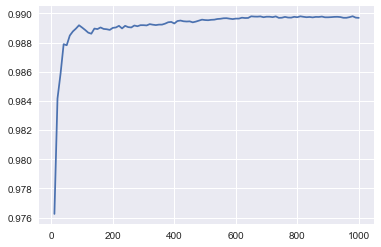

In [0]:
roc_auc = []
accur = []
x = []
for j in range (10, 1001, 10):

    clf = RandomForestClassifier(n_estimators = j, random_state=7)

    clf.fit(x_train, target_train)
    pred = np.array(clf.predict_proba(x_test))

    for i in range(pred.shape[0]):
        if pred[i, 1] > 0.5:
            pred[i, 1] = 1
        else:
            pred[i, 1] = 0
    pred = pred[:, 1]
    pred_prob = np.array(clf.predict_proba(x_test)[:,1])
    target_test = np.array(target_test)
    
    x.append(j)

    roc_auc.append(metrics.roc_auc_score(target_test, pred_prob))

    accur.append(metrics.accuracy_score(target_test, pred))
plt.plot(x, roc_auc)
plt.show()

### 2.6 Важность признаков

Случайный лес позволяет оценить важность признаков. У обученного случайного леса есть аттрибут `feature_importances_`, где храниться важность для каждого признака. Постройте `barplot` с важностью признаков (удобно использовать библиотеку `seaborn`, где можно для каждого столбца передать название признака `train.columns`).

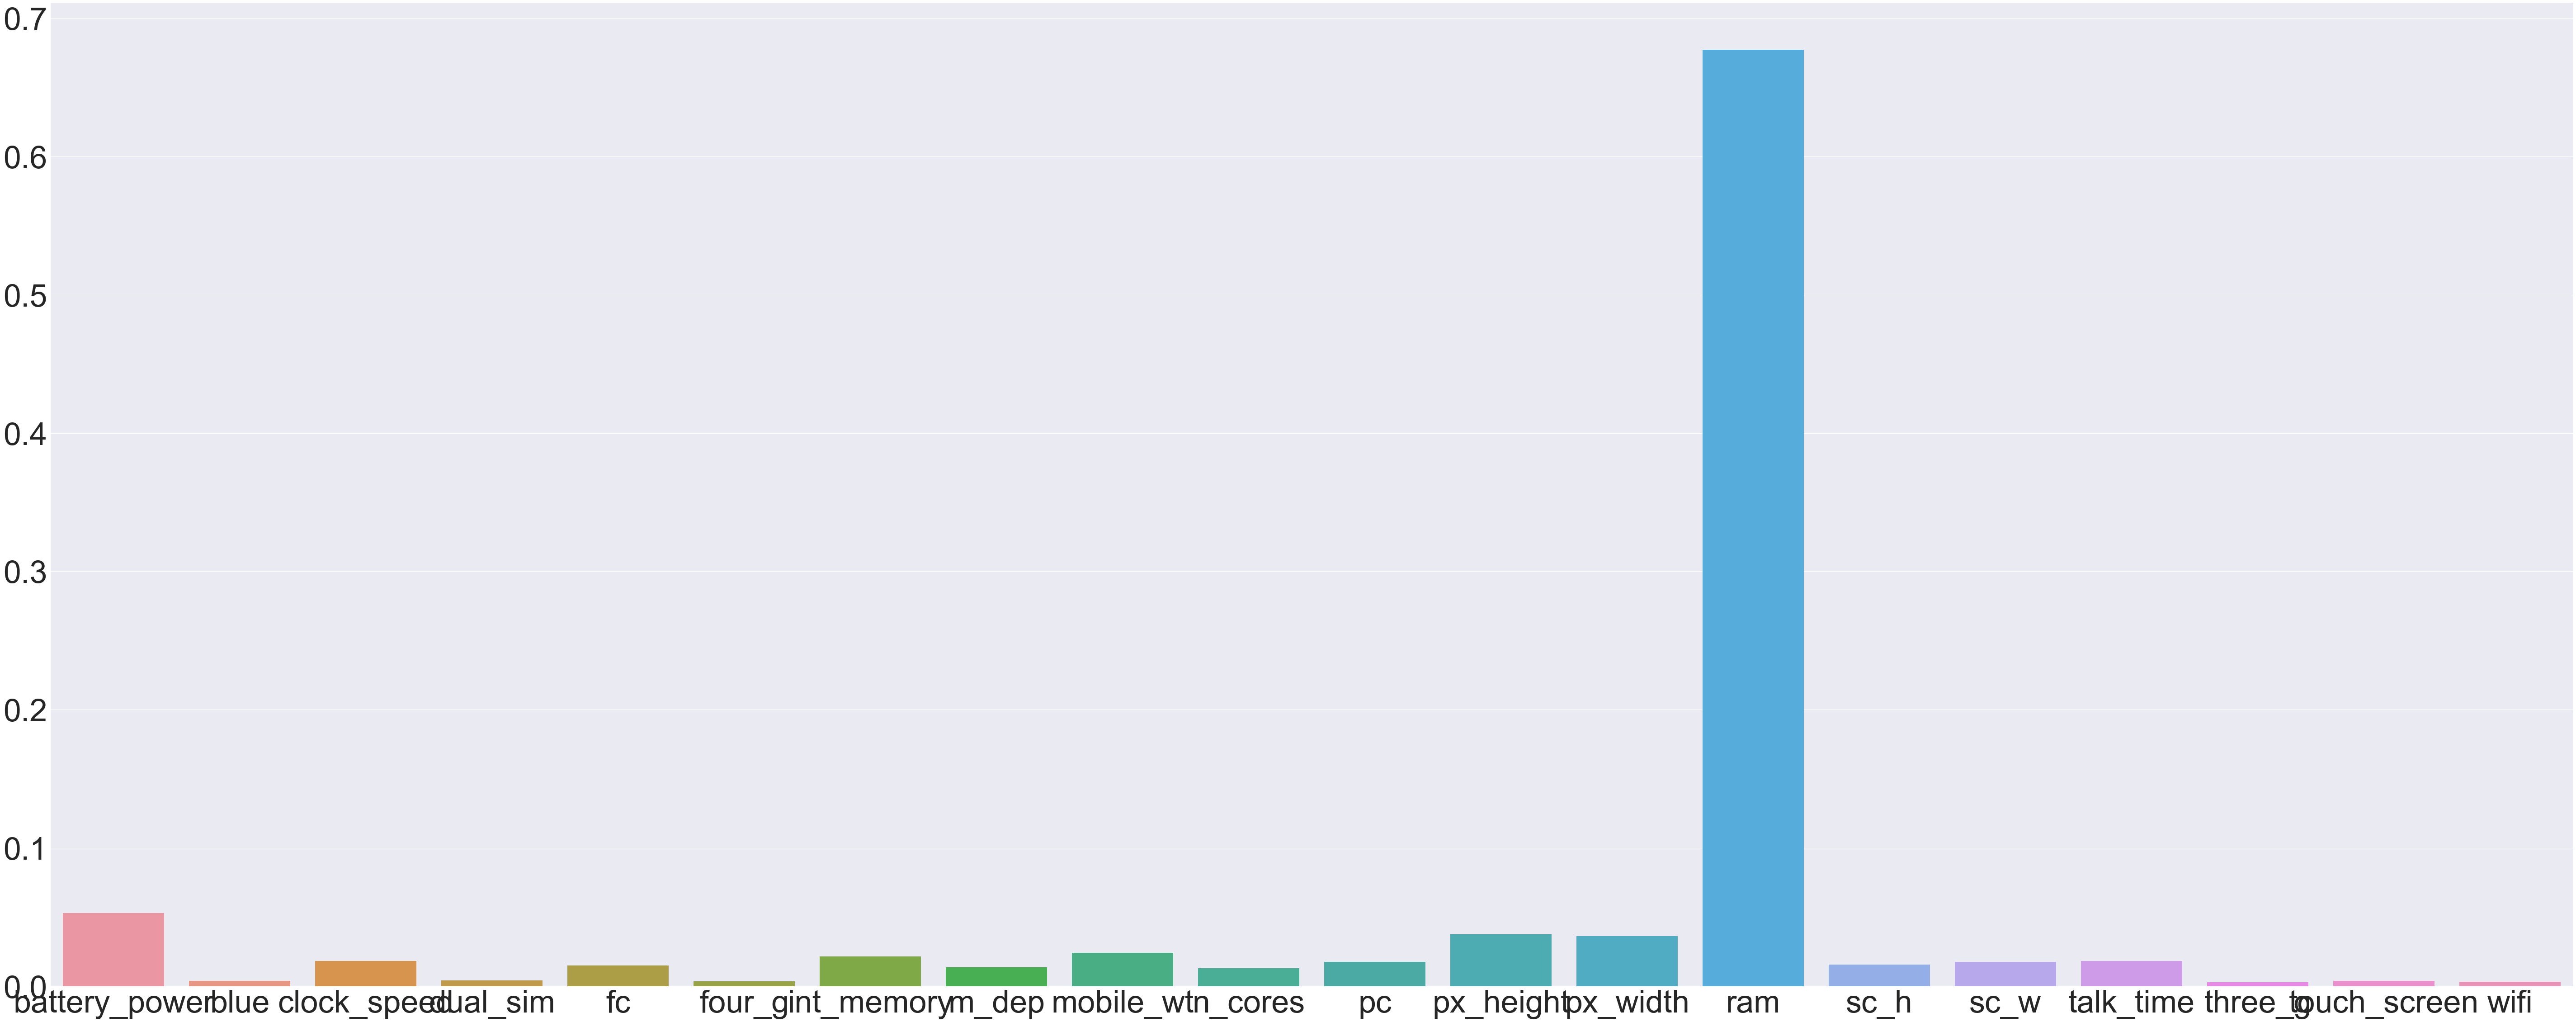

In [0]:
sns.set(font_scale = 7)
fig = sns.barplot(y = clf.feature_importances_, x = train.columns)

sizes = plt.rcParams['figure.figsize']
sizes[0] = 100
sizes[1] = 40

## Выводы

Напишите, что интересного вы узнали в этой работе, в каких экспериментах какие результаты получились.

- При оценивании телефонов самым важным параметром является объём оперативной памяти
- Количество деревьев в случайном лесу влияет на качество модели
- Одно дерево всегда будет переобучаться
- Бэггинг и бутсрап вместе лучше препятствуют переобучению, чем отдельно
- Реализовав логистичискую регрессию вручную я поняла, как она работает